<a href="https://colab.research.google.com/github/gvogiatzis/CS4740/blob/main/CS4740_Lab_Week_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[CS4740 Labs] Week 4:  Convolutional Neural Networks



##Introduction


In this lab we will extend the classifier we have seen previously, to CIFAR10, a more challenging dataset of real (although very low-res) images. The dataset is split into ten classes (see below) and there is significant variability within each class.

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1bn4UqHwT0v7Twk01KS9d_jVlOQpeMaNc'/>
<figcaption>CIFAR10 images</figcaption></center>
</figure>

To classify this dataset correctly we will need to upgrade our network to use convolutional layers. And because convolutions are very computationally demanding, we will see how to offload some of those computations to the GPU, dramatically reducing training times. 


First, let us load up the CIFAR10 dataset, for both training and testing.

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

train_dataset = torchvision.datasets.CIFAR10('.', train=True, download=True,
                             transform=torchvision.transforms.ToTensor())

test_dataset = torchvision.datasets.CIFAR10('.', train=False, download=True,
                             transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=100, shuffle=True)

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified



Let's examine one of the training datapoints:

torch.Size([3, 32, 32])
airplane


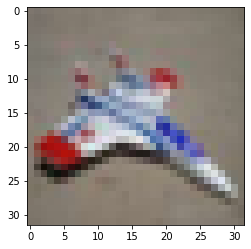

In [2]:
img, target = train_dataset[30]
print(img.shape)
plt.imshow(img.permute([1,2,0]))
print(train_dataset.classes[target])

The images are 32 by 32 and contain 3 color channels which is what we would expect for color images. This is very low res, however if a human is able to correctly classify these images, we should be able to program a neural network. We will be using a convolutional neural network architecture for this task, but first, let us understand how pytorch performs convolutions. 



## A simple convolution network



We define a convolutional layer with the Conv2d class. The constructor takes the input and output number of channels as well as the size of the convolution kernel. Consider the following convolution layer:

In [3]:
conv = nn.Conv2d(3, 16, 5)

This layer receives as input a tensor with 3 channels, and outputs a tensor with 16 channels. The size of the kernel is 5x5. This means that if it is applied on a 3x32x32 tensor it will produce a 16x28x28 tensor output. The 28 comes from the fact that we apply a convolution with a 5-element kernel. A 5-element kernel can slide into 28 (32-5+1) different positions in a 32 element vector.

Also note that pytorch layers expect to be applied to batches of tensors. This makes our lives much easier when we come to training but when applying the layer to a single tensor we must remember to insert a dummy singleton dimension in the start (i.e. 1x3x32x32). We can do this with the unsqueeze command.

Let's check if the layer gives the output we predict:

In [4]:
img, target = train_dataset[30]
img = img.unsqueeze(0) # adding a dummy singleton dimension
out = conv(img)
print(out.shape)

torch.Size([1, 16, 28, 28])


So the convolution layer behaves as expected. Now let's define a conv net architecture. There are litteraly infinite choices but we will keep it simple.

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 64, 5)
        self.conv3 = nn.Conv2d(64, 256, 5)
        self.conv4 = nn.Conv2d(256, 128, 1)
        self.conv5 = nn.Conv2d(128, 10, 1)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.dropout(x)
        x = self.conv5(x)
        return x.view(-1,10)

convnet = ConvNet()

The network consists of a sequence of convolusions, relu's and maxpooling layers. Let's follow it step-by-step, as it processes a 3x32x32 tensor.

Firstly the network applies a Conv2d(3,16,5) convolution to the 3x32x32 tensor, thereby producing a 16x28x28 output. This is then maxpooled with a 2x2 window. This always has the effect of halving the width and height, giving us a 16x14x14 tensor. 

This is then colvolved with a Conv2d(16, 64, 5) layer which produces a 64x10x10 output which when maxpooled gives 64x5x5.

The network then applies a Conv2d(64, 256, 5) layer which produces a tensor with 256 channels but a width and height of 1. I.e. 256x1x1. This makes sense because the 5x5 kernel can only fit in one way to a 5x5 matrix. The 256x1x1 tensor is in fact just a 256-dimensional vector. 

We then see a Conv2d(256, 128, 1), which essentially is a fully connected linear layer masquerading as a convolution! When applied to the 256-dimensional vector it has the effect of multiplying that vector with a 256x128 matrix, giving a 128-dimensional vector as output. 

A convolution that works out as a matrix multiplication may be unintuitive at first but you can convince yourself by working out a simple example. E.g. apply a Conv2d(3, 7, 1) convolution to a 3x1x1 vector to see how you would get a 7x1x1 vector, thereby multiplying with a 3x7 matrix.  It is a useful trick for several reasons, the main one being that we avoid doing unnecessary reshaping of the output tensors. Also, by staying within the convolution world, we can convert any classification network, to a `sliding-window' classifier that can produce classification scores accross all regions of a larger image. 

Finally the network applies a Conv2d(128, 10, 1) layer to the 128x1x1 tensor (again essentially a FC layer), leading to a 10-dimensional vector. This vector is applied as logits which, when fed to a soft-max will give us probabilities for each class.

A word of caution here: in the previous lab, we used a log_softmax output layer and a NLLLoss loss function. Here, we just use a linear output layer (i.e. no processing via soft-max or logs) which forces us to use a CrossEntropyLoss loss function. Either approach is fine. Just make sure you never mix log_softmax with CrossEntropyLoss etc.

Let's test the network on our input image tensor:

In [6]:
convnet(img)

tensor([[-0.0718, -0.0638,  0.0020,  0.0630,  0.0235, -0.0152, -0.0879, -0.0201,
          0.0778,  0.1134]], grad_fn=<ViewBackward>)

The network produces a 10-dimensional vector according to plan. 

And now we can define our training and testing code for each epoch. This is litteraly copy-pasted from the code we used last week. These are the benefits of a well-designed deep learning framework like pytorch: the code for doing things like training and testing needs to change very little despite the architectures changing significantly.

In [7]:
def train(net,dataloader, optimizer,loss_fun):
  net.train()
  for x, t in dataloader:
    optimizer.zero_grad()
    L = loss_fun(net(x), t)
    L.backward()
    optimizer.step()

def test(net,dataloader,loss_fun):
  net.eval()
  total_L = 0
  correct = 0
  with torch.no_grad():
    for x, t in dataloader:
      out = net(x)
      total_L += loss_fun(out, t)
      _,pred = out.max(dim=1)     # this counts how many we got right
      correct += (pred==t).sum() 
  total_L /= len(dataloader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    total_L, correct, len(dataloader.dataset),
    100. * correct / len(dataloader.dataset)))

Unfortunately the only problem here is that our code is CPU based. Because convolutions are so computationally demanding, this will take quite a long time to train. Try it out by running just a single epoch:

In [8]:
from time import perf_counter

tic = perf_counter()

optim_SGD = optim.SGD(convnet.parameters(), lr=0.01, momentum=0.5)

train(convnet, train_loader, optim_SGD, nn.CrossEntropyLoss())
test(convnet, test_loader,  nn.CrossEntropyLoss(reduction='sum'))

toc = perf_counter()
print(f"One epoch of training took {toc - tic:0.4f} seconds")


Test set: Avg. loss: 2.2976, Accuracy: 1051/10000 (11%)

One epoch of training took 37.3649 seconds


It seems one epoch takes about a minute. Deep learning researchers are notoriously impatient when training neural nets. We really don't like to wait, life is just too short! Which is why GPU computing comes to the rescue. Hopefully you are running this code on a GPU-enabled computer (e.g. google colab) which means that with a couple of lines of code you can reap the benefits of super-fast training of deep convnets. 



## Accelerating code with GPUs

We can exploit GPU programming in a variety of ways. The simplest way is to use the `.cuda()` method on a layer, network or a tensor. E.g.

In [9]:
#define tensor
A = torch.rand(1,3,32,32)

# define a conv layer
conv = nn.Conv2d(3, 16, 5)

# move both tensor and layer to the GPU memory
A = A.cuda()
conv = conv.cuda()

# perform convolution on GPU
B = conv(A)

# bring result of computation back to CPU memmory
B = B.cpu()

A slightly more flexible way of achieving the same result would be to use the `.to()` method, which allows us to specify programmaticaly which device we'd like to carry out the computation on. That way if our computer does not have a cuda-enabled GPU we can fall back to slower CPU computations. We can always find out if our computer supports fast GPU computations by using the `torch.cuda.is_available()` command. We can neatly create a torch device object that is either a GPU card or the plain old CPU, depending on our system capabilities, with the following snippet:

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

We can then achieve the same result as the code above with code that will work in non-cuda enabled systems:

In [11]:
#define tensor
A = torch.rand(1,3,32,32)

# define a conv layer
conv = nn.Conv2d(3, 16, 5)

# move both tensor and layer to the GPU memory
A = A.to(device)
conv = conv.to(device)

# perform convolution on GPU
B = conv(A)

# bring result of computation back to CPU memory (if it is already in the CPU this will not do any extra copy)
B = B.cpu()

Pytorch allows us to create tensors directly to the device that we want, instead of in CPU memory first and then copying across to the GPU. So our `A` tensor above can be constructed as:

In [12]:
#define tensor
A = torch.rand(1,3,32,32, device = device)

We can now rewrite our network creation line as: 

In [13]:
convnet = ConvNet().to(device)

And the training and testing code must move the data across to the GPU if available:

In [14]:
def train_gpu(net,dataloader, optimizer,loss_fun):
  net.train()
  for x, t in dataloader:
    x = x.to(device)
    t = t.to(device)
    optimizer.zero_grad()
    L = loss_fun(net(x), t)
    L.backward()
    optimizer.step()

def test_gpu(net,dataloader,loss_fun):
  net.eval()
  total_L = 0
  correct = 0
  with torch.no_grad():
    for x, t in dataloader:
      x = x.to(device)
      t = t.to(device)
      out = net(x)
      total_L += loss_fun(out, t)
      _,pred = out.max(dim=1)     # this counts how many we got right
      correct += (pred==t).sum() 
  total_L /= len(dataloader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    total_L, correct, len(dataloader.dataset),
    100. * correct / len(dataloader.dataset)))

The training code now runs much faster. Let's try one epoch now

In [15]:
from time import perf_counter

tic = perf_counter()

optim_SGD = optim.SGD(convnet.parameters(), lr=0.01, momentum=0.5)
train_gpu(convnet, train_loader, optim_SGD, nn.CrossEntropyLoss())
test_gpu(convnet, test_loader,  nn.CrossEntropyLoss(reduction='sum'))

toc = perf_counter()
print(f"One epoch of gpu-enabled training took {toc - tic:0.4f} seconds")


Test set: Avg. loss: 2.2942, Accuracy: 1157/10000 (12%)

One epoch of gpu-enabled training took 6.6909 seconds


We can now define the epoch code more generally

In [16]:
def run_epochs(num_of_epochs, net, train_loader, test_loader):
    optim_SGD = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)    
    for e in range(num_of_epochs):
        print(f"Epoch: {e+1}/{num_of_epochs}. Training ...")
        train_gpu(net, train_loader, optim_SGD, nn.CrossEntropyLoss())
        print("Testing ...")
        test_gpu(net, test_loader,  nn.CrossEntropyLoss(reduction='sum'))

In [ ]:
convnet = ConvNet().to(device)
run_epochs(100, convnet, train_loader, test_loader)

## Going deep: improving performance by deeper architectures

We have seen how a basic convnet is already outperforming fully connected layers by leveraging translation invariance. Convnets can perform the same operations on images with far less parameters, which makes them easier to train. But can we do even better? 




In [37]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.flatten(1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


In [38]:
vggnet = VGG('VGG16').cuda()
#run_epochs(100, vggnet, train_loader, test_loader)

In [27]:
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
vggnet = VGG('VGG16').cuda()
run_epochs(100, vggnet, train_loader, test_loader)

In [18]:
from torch.utils.tensorboard import SummaryWriter

In [39]:
writer = SummaryWriter()

In [21]:
images, labels = next(iter(train_loader))

grid = torchvision.utils.make_grid(images)

In [41]:
vggnet = vggnet.cpu()

In [42]:
writer.add_image('images', grid, 0)
writer.add_graph(vggnet, images)
writer.close()

In [44]:
writer = SummaryWriter()

for n_iter in range(100):
    writer.add_scalar('Loss2/train', np.random.random(), n_iter)
    writer.add_scalar('Loss2/test', np.random.random(), n_iter)
    writer.add_scalar('Accuracy2/train', np.random.random(), n_iter)
    writer.add_scalar('Accuracy2/test', np.random.random(), n_iter)

In [24]:
%load_ext tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

In [35]:
import numpy as np

writer = SummaryWriter()

for n_iter in range(100):
    writer.add_scalar('Loss/train', np.random.random(), n_iter)
    writer.add_scalar('Loss/test', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/train', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/test', np.random.random(), n_iter)

writer.flush()

In [45]:
writer = SummaryWriter()
writer.add_graph(convnet.cpu(), images)

In [46]:
writer.flush()